In [1]:
import keras, os, pickle, re, sklearn, string, tensorflow
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.layers import Embedding
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split


print('Keras version: \t\t%s' % keras.__version__)
print('Scikit version: \t%s' % sklearn.__version__)
print('TensorFlow version: \t%s' % tensorflow.__version__)

Using TensorFlow backend.


Keras version: 		2.0.8
Scikit version: 	0.19.1
TensorFlow version: 	1.1.0


### Parameter

In [2]:
# EMBEDDING
MAX_NUM_WORDS  = 15000
EMBEDDING_DIM  = 300
MAX_SEQ_LENGTH = 200
USE_GLOVE      = True

# MODEL
FILTER_SIZES   = [3,4,5]
FEATURE_MAPS   = [10,10,10]
DROPOUT_RATE   = 0.5

# LEARNING
BATCH_SIZE     = 200
NB_EPOCHS      = 40
RUNS           = 5
VAL_SIZE       = 0.2

### Preprocessing

In [3]:
def clean_doc(doc):
    """
    Cleaning a document by several methods:
        - Lowercase
        - Removing whitespaces
        - Removing numbers
        - Removing stopwords
        - Removing punctuations
        - Removing short words
    """
    stop_words = set(stopwords.words('english'))
    
    # Lowercase
    doc = doc.lower()
    # Remove numbers
    doc = re.sub(r"[0-9]+", "", doc)
    # Split in tokens
    tokens = doc.split()
    # Remove Stopwords
    tokens = [w for w in tokens if not w in stop_words]
    # Remove punctuation
    tokens = [w.translate(str.maketrans('', '', string.punctuation)) for w in tokens]
    # Tokens with less then two characters will be ignored
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)


def read_files(path):
    documents = list()
    # Read in all files in directory
    if os.path.isdir(path):
        for filename in os.listdir(path):
            with open('%s/%s' % (path, filename)) as f:
                doc = f.read()
                doc = clean_doc(doc)
                documents.append(doc)
    
    # Read in all lines in a txt file
    if os.path.isfile(path):        
        with open(path, encoding='iso-8859-1') as f:
            doc = f.readlines()
            for line in doc:
                documents.append(clean_doc(line))
    return documents

In [4]:
## Sentence polarity dataset v1.0
#negative_docs = read_files('data/rt-polarity.neg')
#positive_docs = read_files('data/rt-polarity.pos')

## IMDB
#negative_docs = read_files('data/imdb/train/neg')
#positive_docs = read_files('data/imdb/train/pos')
#negative_docs_test = read_files('data/imdb/test/neg')
#positive_docs_test = read_files('data/imdb/test/pos')

## Yelp
negative_docs = read_files('data/yelp/train/neg')
positive_docs = read_files('data/yelp/train/pos')
negative_docs_test = read_files('data/yelp/test/neg')
positive_docs_test = read_files('data/yelp/test/pos')

docs   = negative_docs + positive_docs
labels = [0 for _ in range(len(negative_docs))] + [1 for _ in range(len(positive_docs))]

print('Training samples: %i' % len(docs))

Training samples: 200000


## Tokenizer

In [5]:
def max_length(lines):
    """
    Calculate the maximum document length
    """
    return max([len(s.split()) for s in lines])

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(docs)
sequences = tokenizer.texts_to_sequences(docs)

length = max_length(docs)
word_index = tokenizer.word_index

result = [len(x.split()) for x in docs]
print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))
print('vacobulary size: %i / limit: %i' % (len(word_index), MAX_NUM_WORDS))

# Padding all sequences to same length of `MAX_SEQ_LENGTH`
data   = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

Text informations:
max length: 794 / min length: 2 / mean length: 64 / limit length: 200
vacobulary size: 195862 / limit: 15000


## Embeddings

In [6]:
def create_glove_embeddings():
    print('Pretrained embeddings GloVe is loading...')

    embeddings_index = {}
    f = open('glove.6B.%id.txt' % EMBEDDING_DIM)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors in GloVe embedding' % len(embeddings_index))

    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM,
                     input_length=MAX_SEQ_LENGTH,
                     weights=[embedding_matrix],
                     trainable=True
                    )

## Model definition

## Training

In [7]:
import cnn_model

histories = []

for i in range(RUNS):
    print('Running iteration %i/%i' % (i+1, RUNS))
    
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=VAL_SIZE, random_state=42)
    
    emb_layer = None
    if USE_GLOVE:
        emb_layer = create_glove_embeddings()
    
    model = cnn_model.build_cnn(
        embedding_layer=emb_layer,
        num_words=MAX_NUM_WORDS,
        embedding_dim=EMBEDDING_DIM,
        filter_sizes=FILTER_SIZES,
        feature_maps=FEATURE_MAPS,
        max_seq_length=MAX_SEQ_LENGTH,
        dropout_rate=DROPOUT_RATE
    )
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adadelta(clipvalue=3),
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=(X_val, y_val),
        callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                   verbose=1, save_best_only=True, mode='min'),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                  ]
    )
    print()
    histories.append(history.history)

Running iteration 1/5
Pretrained embedding GloVe is loading...


In [8]:
with open('history.pkl', 'wb') as f:
    pickle.dump(histories, f)

## Evaluation

In [9]:
histories = pickle.load(open('history.pkl', 'rb'))

In [10]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'loss'),
                                              get_avg(histories, 'acc')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_acc')))

Training: 	0.1733 loss / 0.9407 acc
Validation: 	0.1724 loss / 0.9418 acc


In [11]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

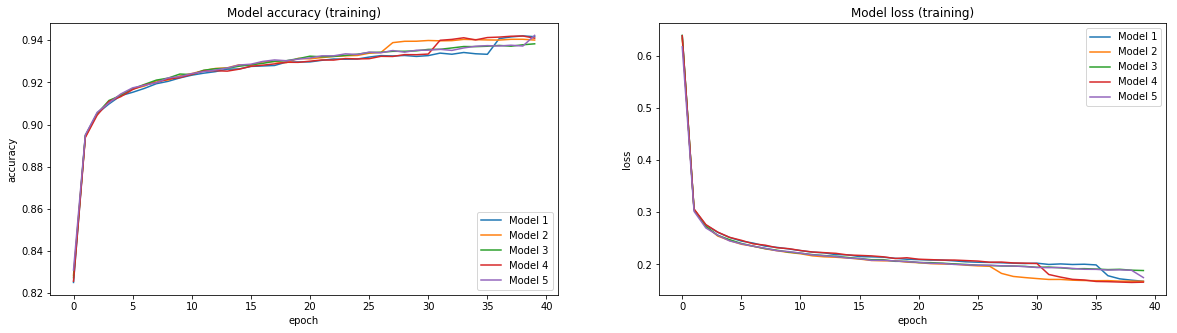

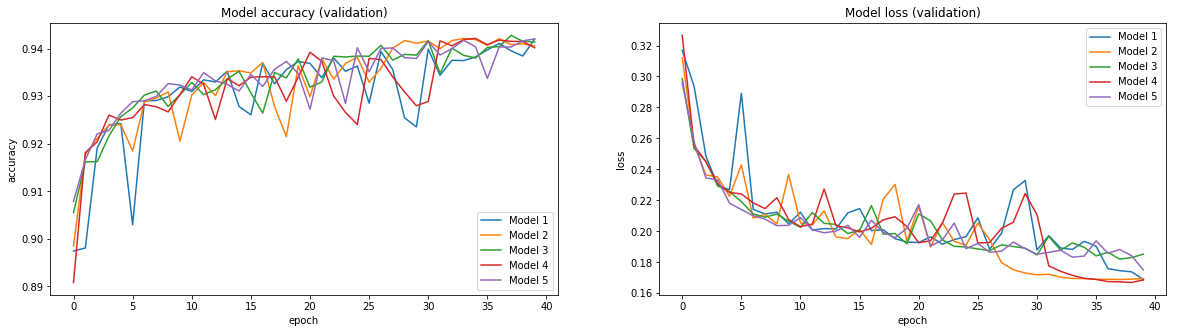

In [12]:
plot_acc_loss('training', histories, 'acc', 'loss')
plot_acc_loss('validation', histories, 'val_acc', 'val_loss')

##### Final test (IMDB / Yelp)

In [13]:
X_test = negative_docs_test + positive_docs_test
y_test = [0 for _ in range(len(negative_docs_test))] + [1 for _ in range(len(positive_docs_test))]

In [14]:
sequences_test = tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(sequences_test, maxlen=MAX_SEQ_LENGTH, padding='post')

In [15]:
test_loss = []
test_accs = []

for i in range(0,RUNS):
    cnn_ = load_model("model-%i.h5" % (i+1))
    
    score = cnn_.evaluate(X_test, y_test, verbose=1)
    test_loss.append(score[0])
    test_accs.append(score[1])
    
    print('Running test with model %i: %0.4f loss / %0.4f acc' % (i+1, score[0], score[1]))
    
print('\nAverage loss / accuracy on testset: %0.4f loss / %0.4f acc' % (np.mean(test_loss),
                                                                        np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss), np.std(test_accs)))

50000/50000 [==============================] - 62s    
Running test with model 1: 0.1764 loss / 0.9389 acc
50000/50000 [==============================] - 62s    
Running test with model 2: 0.1755 loss / 0.9385 acc
50000/50000 [==============================] - 62s    
Running test with model 3: 0.1894 loss / 0.9387 acc
50000/50000 [==============================] - 61s    
Running test with model 4: 0.1737 loss / 0.9404 acc
50000/50000 [==============================] - 62s    
Running test with model 5: 0.1813 loss / 0.9403 acc

Average loss / accuracy on testset: 0.1793 loss / 0.9393 acc
Standard deviation: (+-0.0057) loss / (+-0.0008) acc
